In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats
from scipy.optimize import minimize
import yfinance as yf
import datetime
from IPython.display import display, Latex

plt.style.use('dark_background')

## Processus d'Ornstein-Uhlenbeck

${\Large dX_{t}=\theta (\mu -X_{t})\,dt+\sigma \,dW_{t}}$

### Discrétisation d'Euler
$\Large \Delta x_{t+1} = \theta(\mu - x_t) \Delta t + \sigma \sqrt{\Delta t} \epsilon_t$

In [ ]:
def simulate_ou_process(X0, T, dt, theta, mu, sigma, M, seed=False):

    N = int(T / dt)
    t = np.arange(0, T, dt)
    X = np.zeros((M, N))
    X[:, 0] = X0

    if seed:
        np.random.seed(42)

    for i in range(1, N):
        X[:, i] = X[:, i - 1] + theta * (
            mu - X[:, i - 1]
        ) * dt + sigma * np.sqrt(dt) * np.random.normal(size=M)

    return t, X


def plot_ou_simulation(t, X):

    for j in range(X.shape[0]):
        plt.plot(t, X[j])
    plt.title("Simulation du Processus d'Ornstein-Uhlenbeck")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")

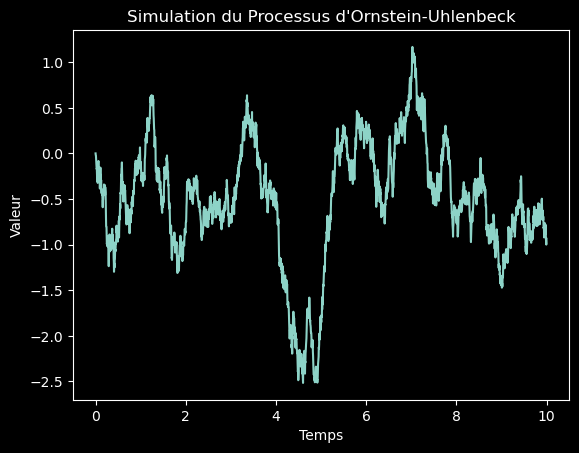

In [ ]:
theta = 1
mu = 0
sigma = 1
X0 = 0
T = 10
dt = 1 / 252
M = 1

t, X = simulate_ou_process(X0, T, dt, theta, mu, sigma, M)
plot_ou_simulation(t, X)

### Estimation du Maximum de Vraisemblance (EMV)

Fonction de densité de probabilité de la loi normale :

$\Large f_\theta(x)=\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}$

Fonction de vraisemblance :

$\Large L(\theta) = f(x_1|\theta)...f(x_n|\theta) = \prod^n_{i=1}f(X_i|\theta)$

Fonction de vraisemblance pour x (nos données) :

$\Large L(\theta|x) = f(x|\theta)$

### Paramètres Optimaux :

$\Large \hat{\theta}(x) = arg \underset{\theta}{max} L(\theta|x)$

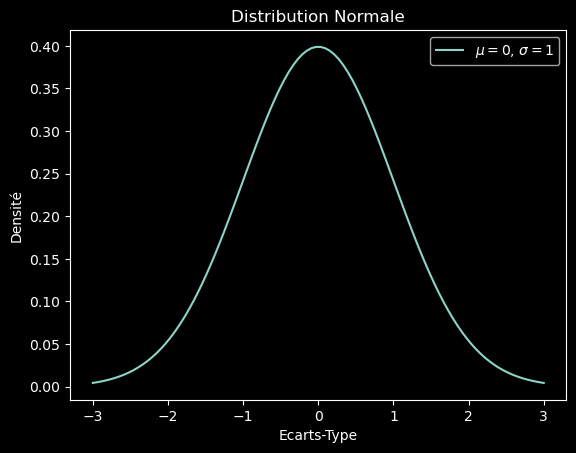

In [ ]:
def plot_normal_distribution(mu=0, sigma=1, num_points=100, estimate=False):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, num_points)
    y = stats.norm.pdf(x, loc=mu, scale=sigma)

    mu_rounded = round(mu, 4)
    sigma_rounded = round(sigma, 4)

    if estimate:
        plt.plot(
            x, y, label=f'$\hat\mu={mu_rounded}$, $\hat\sigma={sigma_rounded}$'
        )
    else:
        plt.plot(x, y, label=f'$\mu={mu_rounded}$, $\sigma={sigma_rounded}$')
    plt.title("Distribution Normale")
    plt.xlabel("Ecarts-Type")
    plt.ylabel("Densité")
    plt.legend()


plot_normal_distribution()

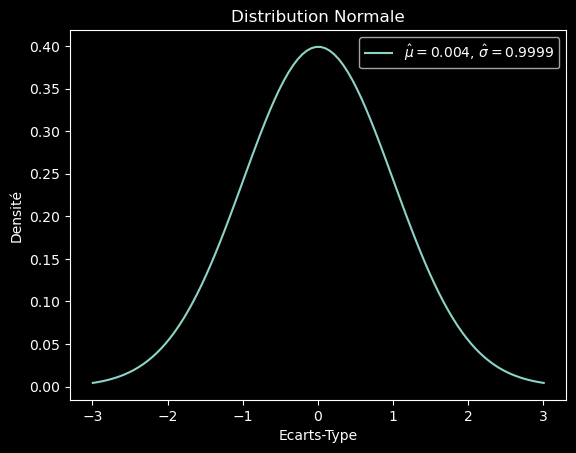

In [ ]:
N = 100000

X = np.random.normal(loc=0, scale=1, size=(N, ))

mu_estimate = X.mean()
sigma_estimate = X.std()

plot_normal_distribution(mu_estimate, sigma_estimate, estimate=True)

### Trouver la fonction de densité du processus d'Ornstein-Uhlenbeck

Trouver l'équation pour $d(X_t)$ avec le calcul d'Itô puis déterminer l'espérance et la variance de $X_t$.

Trouver la dynamique de $X_t$

- ${\Large dX_{t}=\theta (\mu -X_{t})\,dt+\sigma \,dW_{t}}$
- $\Large dX_t= \theta \mu dt -\theta X_t dt+\sigma dW_t$
- $\Large dX_t + \theta X_t dt = \theta \mu dt + \sigma dW_t$

- $\int^T_0 d(e^{\theta t} X_t) = \int^T_0 \theta \mu e^{\theta t} dt + \int^T_0 \sigma e^{\theta t} dW_t$
- $ e^{\theta T} X_T - X_0 = \theta \mu \frac{e^{\theta T}-1}{\theta} + \sigma \int^T_0 e^{\theta t} dW_t$
- $ X_T = X_0 e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \int^T_0 e^{-\theta (T-t)} dW_t$

Trouver l'espérance $E[X_T]$

- $E[X_T] = E[X_0 e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \int^T_0 e^{-\theta (T-t)} dW_t]$
- $E[X_T] = X_0 e^{-\theta T} + \mu (1 - e^{-\theta T})$

Trouver la variance $Var[X_T] = E[(X_T- E[X_T])^2]$.
- $Var[X_T] = E[(\sigma \int^T_0 e^{-\theta (T-t)} dW_t)^2]$
- $Var[X_T] = \sigma^2 \int^T_0 e^{-2\theta (T-t)} dt$
- $Var[X_T] = \sigma^2 \frac{1-e^{-2\theta T}}{2 \theta}$
- $Var[X_T] = \frac{\sigma^2}{2 \theta}(1-e^{-2\theta T}) $

Distribution normale du processus avec l'espérance $E[X_t]$ et la variance $Var[X_t]$.
- $\Large X_t \sim N(\mu, \sigma)$
- $\Large X_t = \mu + \sigma  Z_t$

- $\LARGE X_{t+\Delta t} = X_t e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \sqrt{\frac{(1-e^{-2\theta T})}{2 \theta}} N(0,1)$

### EMV du Processus d'Ornstein-Uhlenbeck
- $\Large X_t \sim N(\overline\mu, \overline{\sigma})$
- $\Large E[X_{t+\delta t}] = X_t e^{-\theta \delta t} + \mu (1 - e^{-\theta \delta t})$
- $\Large Var[X_{t+\delta t}] = \frac{\sigma^2}{2 \theta}(1-e^{-2\theta \delta t}) $

 $\Large f_\overline{\theta} (x_{t+\delta t} | x_t, \theta, \mu, \sigma)=\frac{1}{\sqrt{2\pi \overline{\sigma}^2}} e^{\frac{-(x-\overline\mu)^2}{2 \overline{\sigma}^2}}$

$\Large \overline\mu(x_t, \theta, \mu) = x_t e^{-\theta \delta t} + \mu (1 - e^{-\theta \delta t})$

In [ ]:
def _mu(x, dt, theta, mu):
    ett = np.exp(-theta * dt)
    return x * ett + mu * (1 - ett)

$\Large \overline{\sigma}(\theta, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\theta \delta t})}{2 \theta}}$

In [ ]:
def _sigma(dt, theta, sigma):
    e2tt = np.exp(-2 * theta * dt)
    return sigma * np.sqrt((1 - e2tt) / (2 * theta))

Fonction de log-vraisemblance :

$\Large l(\theta) = \sum^N_{i=1} log f_\theta (x_i)$

In [ ]:
def log_likelihood(theta_estimate, x, dt=1 / 252):
    theta = theta_estimate[0]
    mu = theta_estimate[1]
    sigma = theta_estimate[2]

    x_dt = x[1:]
    x_t = x[:-1]

    mu_OU = _mu(x_t, dt, theta, mu)
    sigma_OU = _sigma(dt, theta, sigma)

    l_theta_estimate = np.sum(
        np.log(stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU))
    )

    return -l_theta_estimate

In [ ]:
def theta_pos(theta_estimate):
    return theta_estimate[0]


def sigma_pos(theta_estimate):
    return theta_estimate[2]


def optimize_ou_parameters(data, theta0=[1, 1, 1]):
    constraints = [
        {
            'type': 'ineq',
            'fun': theta_pos
        }, {
            'type': 'ineq',
            'fun': sigma_pos
        }
    ]
    return minimize(
        fun=log_likelihood, x0=theta0, args=(data, ), constraints=constraints
    )

In [ ]:
def estimate_ou_parameters(data, theta0=[1, 1, 1]):

    optimize = optimize_ou_parameters(data, theta0)

    theta = round(optimize.x[0], 3)
    mu = round(optimize.x[1], 3)
    sigma = round(optimize.x[2], 3)

    theta_estimate_ = f'$\Large\\hat{{\\theta}} = {theta}$'
    mu_estimate_ = f'$\Large\\hat{{\\mu}} = {mu}$'
    sigma_estimate_ = f'$\Large\\hat{{\\sigma}} = {sigma}$'

    display(Latex(theta_estimate_))
    display(Latex(mu_estimate_))
    display(Latex(sigma_estimate_))

    return theta, mu, sigma

In [11]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=7300)

prices_ohlc = yf.download('^GSPC', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


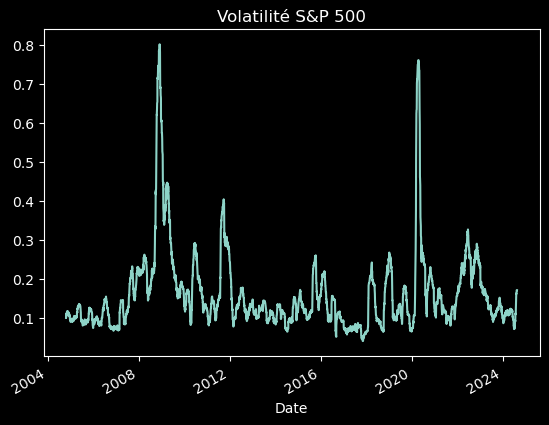

In [ ]:
sp_log_returns = np.log(prices_ohlc.Close / prices_ohlc.Close.shift(1)).dropna()

sp_volatility = (sp_log_returns.rolling(window=40).std() *
                 np.sqrt(252)).dropna()

sp_volatility.plot()
plt.title('Volatilité S&P 500')

In [ ]:
theta, mu, sigma = estimate_ou_parameters(sp_volatility, [1, 1, 1])

C:\Users\leyso\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == "":


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
def simulate_continuous_ou_process(X0, T, theta, mu, sigma, M):
    Z = np.random.normal(size=(M))
    drift_OU = _mu(X0, T, theta, mu)
    diffusion_OU = _sigma(T, theta, sigma)
    return drift_OU + diffusion_OU * Z


def plot_kde(data, title="Titre", xlabel="x", ylabel="y"):
    kde = stats.gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    mode_peak = x_vals[np.argmax(kde_vals)]

    sns.kdeplot(data, shade=True)
    plt.axvline(mode_peak, linestyle='--', label=f'Mode: {mode_peak:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

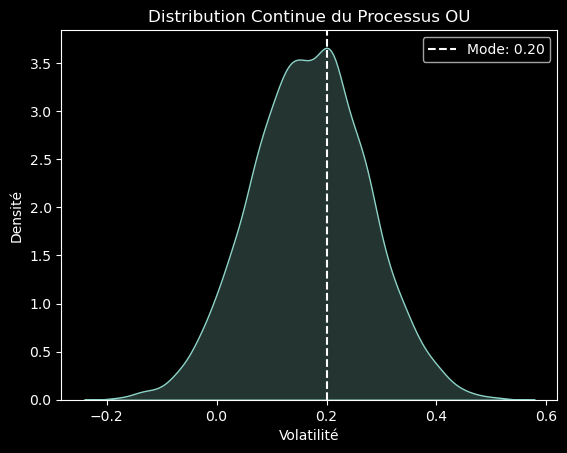

In [ ]:
T = 10
M = 10000
X0 = sp_volatility[-1]

simulated_data = simulate_continuous_ou_process(X0, T, theta, mu, sigma, M)
plot_kde(
    simulated_data,
    title="Distribution Continue du Processus OU",
    xlabel="Volatilité",
    ylabel="Densité"
)

In [ ]:
def simulate_and_compare_data(
    data, theta, mu, sigma, start_date, M=1, seed=False
):
    T = len(data) / 252
    dt = 1 / 252

    t, OU = simulate_ou_process(data[0], T, dt, theta, mu, sigma, M, seed=seed)
    OU = OU[0]

    time_index = pd.date_range(start=start_date, periods=len(data),
                               freq='B')[-len(OU):]

    min_length = min(len(OU), len(data[-len(OU):]))
    OU = OU[:min_length]
    array = data[-min_length:]
    time_index = time_index[:min_length]

    def compare_statistics(real_data, simulated_data):
        stats_comparison = {
            "Moyenne": (np.mean(real_data), np.mean(simulated_data)),
            "Écart-type": (np.std(real_data), np.std(simulated_data)),
            "Skewness": (stats.skew(real_data), stats.skew(simulated_data)),
            "Kurtosis":
                (stats.kurtosis(real_data), stats.kurtosis(simulated_data))
        }
        return pd.DataFrame(
            stats_comparison, index=["Données Réelles", "Processus OU"]
        )

    print(compare_statistics(array, OU))

    plt.figure(figsize=(10, 6))
    plt.plot(time_index, OU, label="Processus OU")
    plt.plot(time_index, array, label="Données Réelles", alpha=0.7)
    plt.title("Processus OU et Données Réelles")
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.legend()

                  Moyenne  Écart-type  Skewness   Kurtosis
Données Réelles  0.160841    0.106504  3.102998  12.484483
Processus OU     0.200303    0.082354 -0.098450  -0.604582


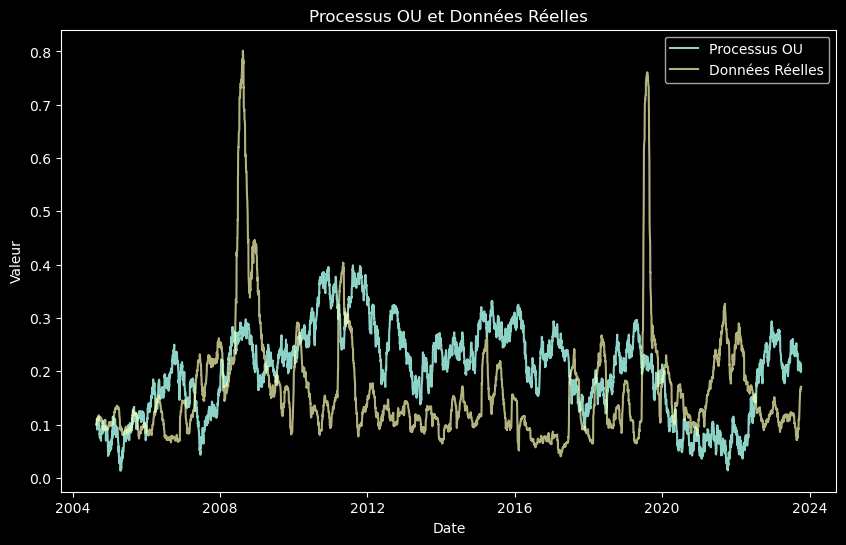

In [17]:
simulate_and_compare_data(sp_volatility, theta, mu, sigma, start_date)

In [18]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=7300)

prices_ohlc = yf.download('EURUSD=X', start=start_date, end=end_date)
eurusd_close = prices_ohlc['Close'].dropna()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
theta, mu, sigma = estimate_ou_parameters(eurusd_close, [1, 1, 1])

C:\Users\leyso\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == "":


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

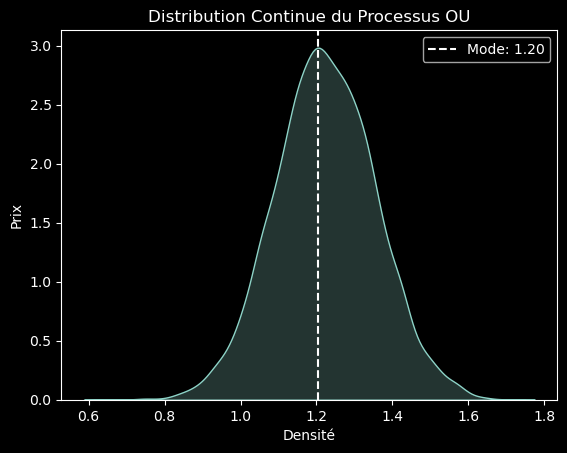

In [ ]:
Time = 10
M = 10000
X0 = eurusd_close[0]

simulated_data = simulate_continuous_ou_process(X0, Time, theta, mu, sigma, M)
plot_kde(
    simulated_data,
    title="Distribution Continue du Processus OU",
    xlabel="Densité",
    ylabel="Prix"
)

                  Moyenne  Écart-type  Skewness  Kurtosis
Données Réelles  1.232182    0.129871  0.411015 -0.602370
Processus OU     1.217886    0.133478  0.373530 -0.676694


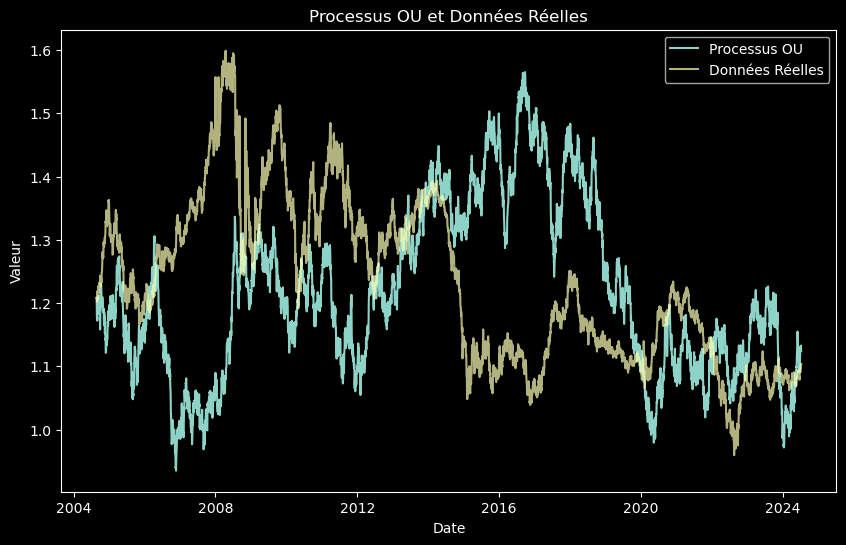

In [21]:
simulate_and_compare_data(eurusd_close, theta, mu, sigma, start_date)

In [ ]:
def simulate_and_concatenate_data(
    data, theta, mu, sigma, start_date, M=1, seed=False
):
    T = len(data) / 252
    dt = 1 / 252

    t, OU = simulate_ou_process(data[-1], T, dt, theta, mu, sigma, M, seed=seed)
    OU = OU[0]

    real_data_length = len(data)
    ou_data_length = len(OU)
    time_index_real = pd.date_range(
        start=start_date, periods=real_data_length, freq='B'
    )
    time_index_ou = pd.date_range(
        start=time_index_real[-1] + pd.Timedelta(days=1),
        periods=ou_data_length,
        freq='B'
    )

    concatenated_data = np.concatenate((data, OU))
    concatenated_time_index = np.concatenate((time_index_real, time_index_ou))

    concatenated_series = pd.Series(
        concatenated_data, index=concatenated_time_index
    )

    return concatenated_series


def plot_concatenated_series(
    concatenated_series,
    ou_start_date,
    title="Mystère",
    xlabel="Temps",
    ylabel="Valeur"
):
    plt.figure(figsize=(10, 6))
    plt.plot(concatenated_series.index, concatenated_series)
    #    plt.axvline(x=ou_start_date, color='red', linestyle='--', label="Début du Processus OU")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


#    plt.legend()

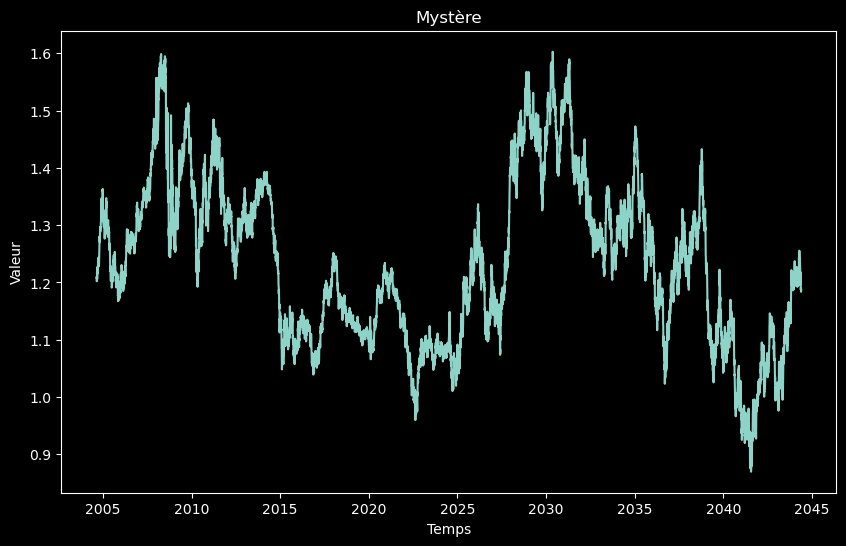

In [ ]:
concatenated_series = simulate_and_concatenate_data(
    eurusd_close, theta, mu, sigma, start_date, seed=True
)
ou_start_date = concatenated_series.index[len(eurusd_close)]
plot_concatenated_series(concatenated_series, ou_start_date)